This code works to 1. create a heatmap that shows the probability of beaching. High value areas represent high likelyhood of a drifter beaching if it were to 'start' there. 2.

In [2]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters')
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [63]:
# dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.geometry import Point

In [3]:
# loading files
metadata = pd.read_csv('drifter data/global drifter program/csv files/GDP_metadata.csv')
runD = pd.read_csv('drifter data/global drifter program/csv files/GDP_RunAground_drouged.csv')
runUnD = pd.read_csv('drifter data/global drifter program/csv files/GDP_RunAground_undrouged.csv')
nRunD = pd.read_csv('GDP_NonRunAground_drouged-004.csv')
nRunUnD = pd.read_csv('GDP_NonRunAground_undrouged-006.csv')

In [85]:
# explore file shapes
print('runD: ' + str(np.shape(runD))) # run aground drogued 
print('runUnD: ' + str(np.shape(runUnD))) # run aground undrogued
print('nRunD: ' + str(np.shape(nRunD))) # not run aground drogued
print('nRunUnD: ' + str(np.shape(nRunUnD))) # not run aground undrogued
print('metadata: ' + str(np.shape(metadata))) # metadata

runD: (14265865, 6)
runUnD: (23068321, 6)
nRunD: (51183961, 6)
nRunUnD: (77236186, 6)
metadata: (17324, 3)


In [226]:
RunD_starts = runD.drop_duplicates(subset='ID', keep='first') # drops all but the starting location
nRunD_starts = nRunD.drop_duplicates(subset='ID', keep='first') # drops all but the starting location
runUnD_starts = runUnD.drop_duplicates(subset='ID', keep='first')
nRunUnD_starts = nRunUnD.drop_duplicates(subset='ID', keep='first')

#. ignores all that do not run aground near land
for index, row in RunD_starts.iterrows():
    point = Point(row['lon'], row['lat'])
    
    # Check if the point is near the coast by intersecting with the coastline geometries
    near_coast = world['geometry'].intersects(point)
    
    if near_coast.any():

In [232]:
# get lats and lons separated and assigns value 1 to all that run aground and 0 to those that do not
RunD_lats = np.array(RunD_starts['lat'])#.tolist()
RunD_longs = np.array(RunD_starts['lon'])#.tolist()
RunD_values = np.ones(len(RunD_starts))

nRunD_lats = np.array(nRunD_starts['lat'])#.tolist()
nRunD_longs = np.array(nRunD_starts['lon'])#.tolist()
nRunD_values = np.zeros(len(nRunD_starts))

runUnD_lats = np.array(runUnD_starts['lat'])
runUnD_longs = np.array(runUnD_starts['lon'])
runUnD_values = np.ones(len(runUnD_starts))

nRunUnD_lats = np.array(nRunUnD_starts['lat'])
nRunUnD_longs = np.array(nRunUnD_starts['lon'])
nRunUnD_values = np.zeros(len(nRunUnD_starts))
# bootstrap the data to reduce size
#RunD_lats_boot = np.random.choice(RunD_lats, size=100, replace=False)
#nRunD_starts_boot = np.random.choice(nRunD_starts, size=100000, replace=False)

In [233]:
lats = np.concatenate((RunD_lats, runUnD_lats, nRunD_lats, nRunUnD_lats))
longs = np.concatenate((RunD_longs, runUnD_longs, nRunD_longs, nRunUnD_longs))
values = np.concatenate((RunD_values, runUnD_values, nRunD_values, nRunUnD_values))

In [234]:
# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

valid_lats = []
valid_lons = []
valid_values = []

for lat, lon, value in zip(lats, longs, values):
    # Create a Point geometry for each latitude and longitude
    point = Point(lon, lat)
    
    # Check if the point is over land (coastlines)
    if not any(world['geometry'].intersects(point)):
        valid_lats.append(lat)
        valid_lons.append(lon)
        valid_values.append(value)

In [241]:
# Define the grid for the heatmap
n_lons, n_lats = 90, 45 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

heatmap_data = np.full((n_lats, n_lons), np.nan)
for i in range(n_lats):
    for j in range(n_lons):
        mask = ((valid_lats >= lat_bins[i]) & (valid_lats <= lat_bins[i+1]) &
                (valid_lons >= lon_bins[j]) & (valid_lons <= lon_bins[j+1]))
        if np.any(mask):
            heatmap_data[i, j] = np.mean(np.array(valid_values)[mask])


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()



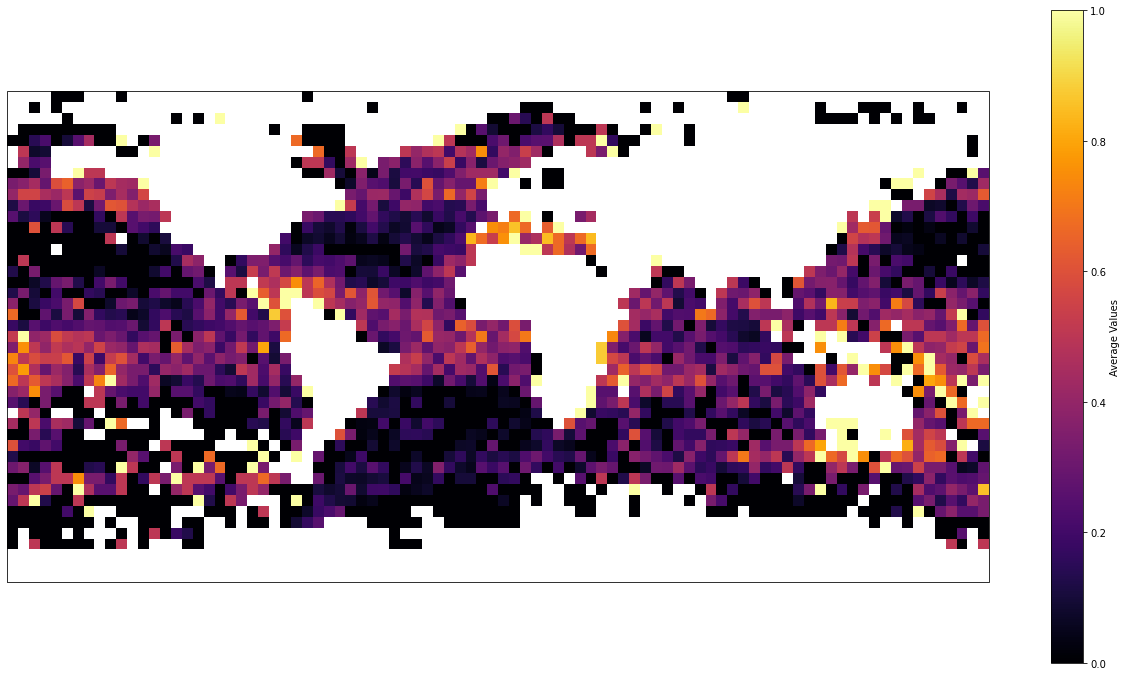

In [242]:
fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()  # setting up coastlines

cmap = plt.get_cmap('inferno')
cmap.set_bad('white')

lon_centers = (lon_bins[1:] + lon_bins[:-1]) / 2
lat_centers = (lat_bins[1:] + lat_bins[:-1]) / 2

lon_centers = (lon_bins[1:] + lon_bins[:-1]) / 2
lat_centers = (lat_bins[1:] + lat_bins[:-1]) / 2
mesh = ax.pcolormesh(lon_centers, lat_centers, heatmap_data, cmap = cmap,
                     transform=ccrs.PlateCarree())
plt.colorbar(mesh, label='Average Values')


plt.show()